In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

## Import Data

In [94]:
train = pd.read_csv('C:/Users/Moussa/Desktop/github/deeptweets/train.csv')
test = pd.read_csv('C:/Users/Moussa/Desktop/github/deeptweets/test.csv')

In [95]:
train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [96]:
test.head()

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...


## Text Cleaning and Preprocessing

In [97]:
class TweetCleaner:
    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        return [self._clean(tweet) for tweet in X]

    def _clean(self, tweet):
        tweet = self.clean_tweet(tweet)
        tweet = self.remove_urls(tweet)
        tweet = self.lowercase_tweet(tweet)
        return tweet
    
    def clean_tweet(self,tweet):
        cleaned_tweet = re.sub(r"[^\w\s#@]", "", tweet)
        return cleaned_tweet
    def remove_urls(self,tweet):
        cleaned_tweet = re.sub(r"http\S+|www\S+|pic.twitter.com\S+", "", tweet)
        return cleaned_tweet.strip()
    def lowercase_tweet(self,tweet):
        lowercase_text = tweet.lower()
        return lowercase_text

train['cleaned_tweet'] = train['TweetText'].apply(TweetCleaner().clean_tweet)
train['cleaned_tweet'] = train['cleaned_tweet'].apply(TweetCleaner().remove_urls)
train['cleaned_tweet'] = train['cleaned_tweet'].apply(TweetCleaner().lowercase_tweet)
train[['TweetText', 'cleaned_tweet']].head()

,TweetText,cleaned_tweet
0,'#SecKerry: The value of the @StateDept and @U...,#seckerry the value of the @statedept and @usa...
1,'@rraina1481 I fear so',@rraina1481 i fear so
2,'Watch video highlights of the #wwc13 final be...,watch video highlights of the #wwc13 final bet...
3,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,rt @chelscanlan at nitro circus at #albertpark...
4,'@cricketfox Always a good thing. Thanks for t...,@cricketfox always a good thing thanks for the...


## Tokenization

In [98]:
class TweetTokenizer:
    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        return [self._tokens(tweet) for tweet in X]

    def _tokens(self, tweet):
        tokens = self.tokenize_tweet(tweet)
        return tokens
    def tokenize_tweet(self, tweet):
        tokens = tweet.split()
        return tokens

train['tokens'] = train['cleaned_tweet'].apply(TweetTokenizer().tokenize_tweet)
train[['TweetText', 'tokens']].head()

,TweetText,tokens
0,'#SecKerry: The value of the @StateDept and @U...,"[#seckerry, the, value, of, the, @statedept, a..."
1,'@rraina1481 I fear so',"[@rraina1481, i, fear, so]"
2,'Watch video highlights of the #wwc13 final be...,"[watch, video, highlights, of, the, #wwc13, fi..."
3,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,"[rt, @chelscanlan, at, nitro, circus, at, #alb..."
4,'@cricketfox Always a good thing. Thanks for t...,"[@cricketfox, always, a, good, thing, thanks, ..."


## Stopword Removal

In [99]:
stop_words = stopwords.words("english")
class TweetStopwordRemover:
  def fit(self, X, y=None):
        return self  

  def transform(self, X):
        return [self._stopwords(tweet) for tweet in X]

  def _stopwords(self, tweet):
      stopwords = self.remove_stopwords(tweet)
      return stopwords
  def remove_stopwords(self, text):
    text = text.lower() 
    text = "".join([char for char in text if char.isalnum() or char == " "])
    words = [w for w in text.split() if w not in stop_words]  
    return " ".join(words)

In [100]:

train['FilteredTweet'] = train['cleaned_tweet'].apply(TweetStopwordRemover().remove_stopwords)
train[['TweetText', 'FilteredTweet']].head()

,TweetText,FilteredTweet
0,'#SecKerry: The value of the @StateDept and @U...,seckerry value statedept usaid measured dollar...
1,'@rraina1481 I fear so',rraina1481 fear
2,'Watch video highlights of the #wwc13 final be...,watch video highlights wwc13 final australia w...
3,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,rt chelscanlan nitro circus albertpark theymak...
4,'@cricketfox Always a good thing. Thanks for t...,cricketfox always good thing thanks feedback


## Stemming or Lemmatization

In [101]:
class TweetStemmer:
  def fit(self, X, y=None):
        return self  

  def transform(self, X):
        return [self._stem(tweet) for tweet in X]

  def _stem(self, tweet):
        stemmed_tweet = self.stem_tweet(tweet)
        return stemmed_tweet
  def stem_tweet(self, text):
    text = text.lower()
    text = "".join([char for char in text if char.isalnum() or char == " "]) 
    stemmer = PorterStemmer()  
    words = [stemmer.stem(w) for w in text.split() if w not in stop_words] 
    return " ".join(words)

In [102]:
train['StemmedTweet'] = train['cleaned_tweet'].apply(TweetStemmer().stem_tweet)
train[['TweetText', 'StemmedTweet']].head()

,TweetText,StemmedTweet
0,'#SecKerry: The value of the @StateDept and @U...,seckerri valu statedept usaid measur dollar te...
1,'@rraina1481 I fear so',rraina1481 fear
2,'Watch video highlights of the #wwc13 final be...,watch video highlight wwc13 final australia we...
3,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,rt chelscanlan nitro circu albertpark theymake...
4,'@cricketfox Always a good thing. Thanks for t...,cricketfox alway good thing thank feedback


## creating a  model

In [103]:
X_train, X_test, y_train, y_test = train_test_split(train['StemmedTweet'], train['Label'], test_size=0.2, random_state=42)

In [104]:
class Vectorizer:
    def __init__(self, max_features=5000):
        self.vectorizer = TfidfVectorizer(max_features=max_features)

    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        return self.vectorizer.transform(X)

In [105]:
pipeline = Pipeline([
    ('TweetCleaner', TweetCleaner()),
    ('TweetStopwordRemover', TweetStopwordRemover()),
    ('TweetStemmer', TweetStemmer()),
    ('vectorizer', Vectorizer())
])

## algorithm Logistic Regression

In [106]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [108]:
logistic_regression_model = LogisticRegression()
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
]
gridSearch = GridSearchCV(logistic_regression_model, param_grid, cv=3, scoring='accuracy', return_train_score=True)
gridSearch.fit(X_train, y_train)

print("Best parameters: ", gridSearch.best_params_)
print("Best cross-validation score: {:.8f}".format(gridSearch.best_score_))

c:\Users\Moussa\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Moussa\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Best parameters:  {'C': 10, 'penalty': 'l2'}
Best cross-validation score: 0.94137931


In [109]:
logistic_regression_model.fit(X_train, y_train)

LogisticRegression()

In [110]:
y_pred = logistic_regression_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9478927203065134


In [111]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Politics       0.96      0.93      0.95       638
      Sports       0.94      0.96      0.95       667

    accuracy                           0.95      1305
   macro avg       0.95      0.95      0.95      1305
weighted avg       0.95      0.95      0.95      1305



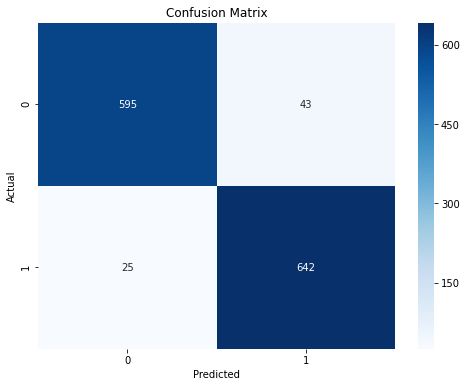

In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



## Algorithem SVM

In [113]:
from sklearn.svm import SVC
svm_model = Pipeline([
    ('TweetCleaner', TweetCleaner()),
    ('TweetStopwordRemover', TweetStopwordRemover()),
    ('TweetStemmer', TweetStemmer()),
    ('vectorizer', Vectorizer()),
    ('svm', SVC())
])

In [114]:
svm_model.fit(X_train, y_train)

TypeError: expected string or bytes-like object

In [204]:
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9547892720306513


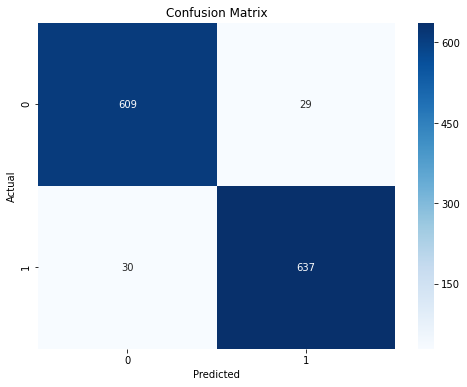

In [205]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [206]:
test = pd.read_csv('C:/Users/Moussa/Desktop/deeptweets/test.csv')
test


,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...
...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin..."
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR..."


In [184]:
tst=logistic_regression_model.predict(X_test)

NotFittedError: The TF-IDF vectorizer is not fitted

In [71]:
test['Label'] = tst
test

,TweetId,TweetText,PreprocessedText,Label
0,306486520121012224,'28. The home side threaten again through Maso...,28 the home side threaten again through mason ...,Sports
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....,mrbrown aulia thx for asking see httptcoygjepj...,Sports
2,289531046037438464,'@Sochi2014 construction along the shores of t...,sochi2014 construction along the shores of the...,Politics
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...,seckerryu2019s remarks after meeting with fore...,Politics
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...,the iplauction has begun ricky ponting is the ...,Sports
...,...,...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...,qualifier 1 and eliminator games will be playe...,Politics
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin...",reesedward hi edward its not a peacekeeping mi...,Sports
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...,perera was sunrisersipl first ipl purchase ipl...,Sports
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR...",seckerry thanks to senator timkaine reproberth...,Politics


In [72]:
test.to_csv('C:/Users/Moussa/Desktop/deeptweets/submission.csv')